In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import geoist.snoopy.tsa as tsa
%matplotlib inline

In [3]:
# parameters for loading data
data_path = pathlib.Path(tsa.__file__).parent
orig_file = pathlib.Path(data_path,"data",'50002_1_2312.txt')
na_values = None
date_format = None

# parameters for processing data
thresh_hold = 200.0
window_size = 50

# parameters for saving data
res_file = 'despike.txt'

In [216]:
# load data
data=pd.read_csv(pathlib.Path(orig_file),parse_dates=[[0,1]],header=None,delim_whitespace=True,index_col=[0],na_values=na_values)
data.index.name = 'time'
data.columns = ['origin_data']

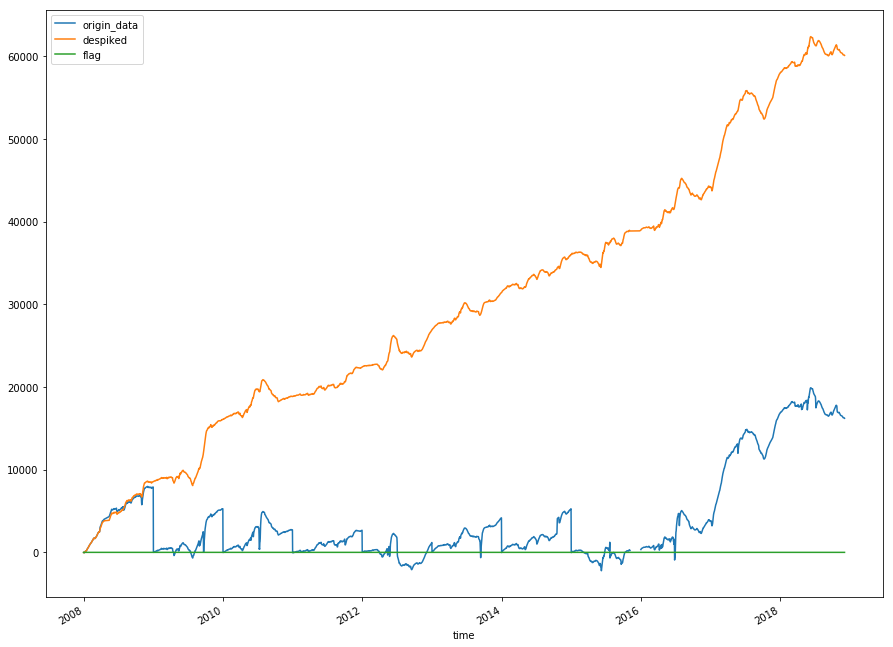

In [5]:
# despike
data['despiked'],data['flag'] = tsa.despike_v2(data['origin_data'].interpolate(),th=thresh_hold)
data.plot(figsize=(15,12))

Augmented Dickey–Fuller test for despiked data:
  adf: -0.4963331534709667
  p-value: 0.8927300729787283
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


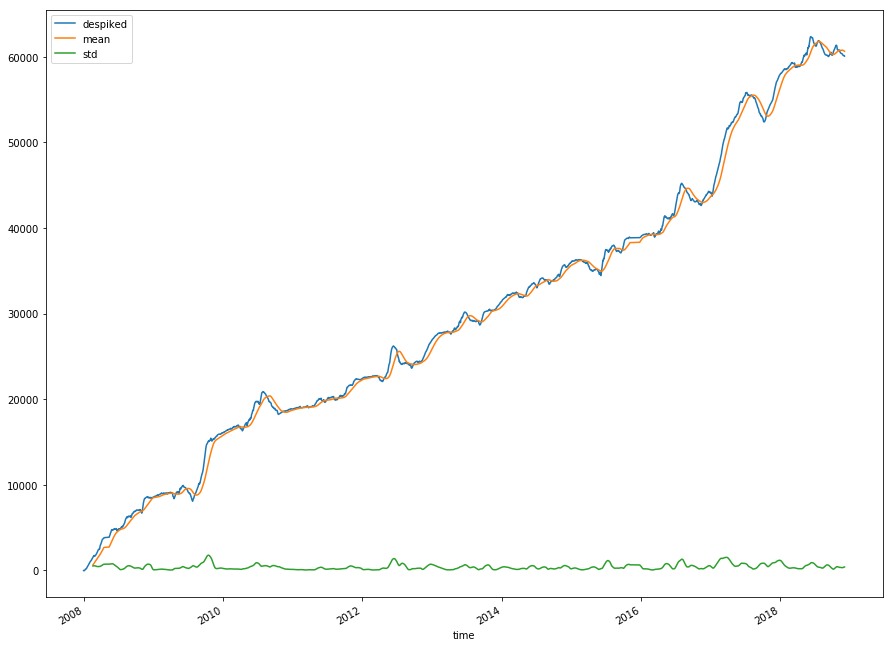

In [5]:
# test stationary
res = tsa.adfuller(data['despiked'].values)
tsa.print_adf(res,'despiked data')
data['mean'] = data['despiked'].rolling(window=window_size).mean()
data['std'] = data['despiked'].rolling(window=window_size).std()
data.plot(figsize=(15,12),y=['despiked','mean','std'])

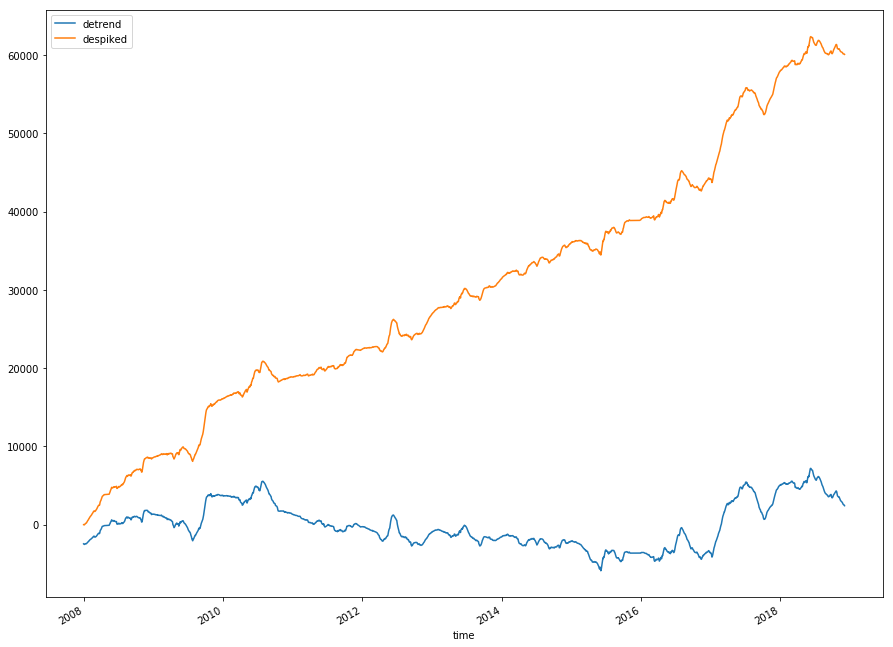

In [6]:
# detrend
data['detrend'] = tsa.detrend(data['despiked'])
data.plot(figsize=(15,12),y=['detrend','despiked'])

Augmented Dickey–Fuller test for detrended data:
  adf: -2.4215170263186088
  p-value: 0.13575524964385655
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


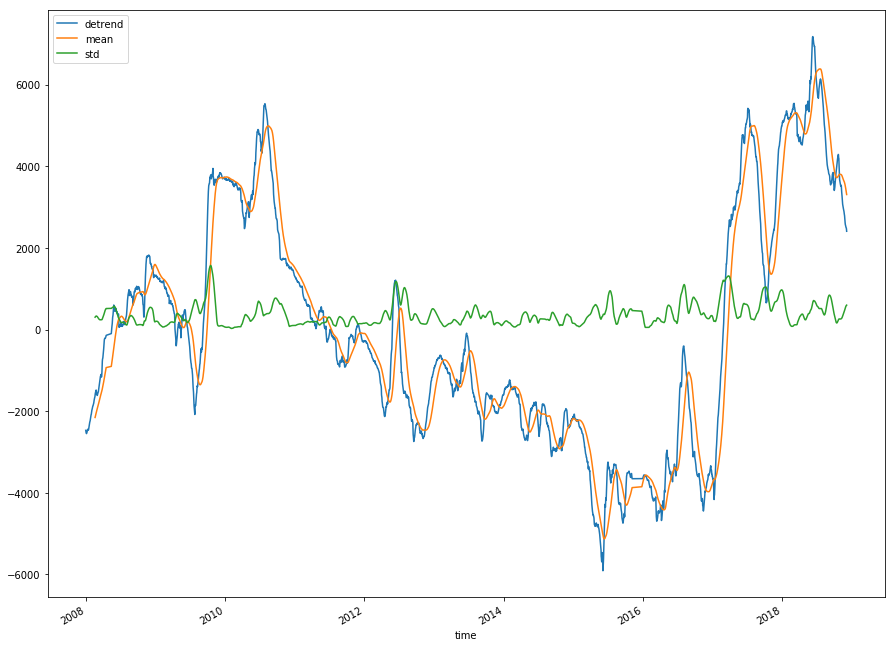

In [7]:
# test stationary again
res = tsa.adfuller(data['detrend'].values)
tsa.print_adf(res,'detrended data')
data['mean'] = data['detrend'].rolling(window=window_size).mean()
data['std'] = data['detrend'].rolling(window=window_size).std()
data.plot(figsize=(15,12),y=['detrend','mean','std'])

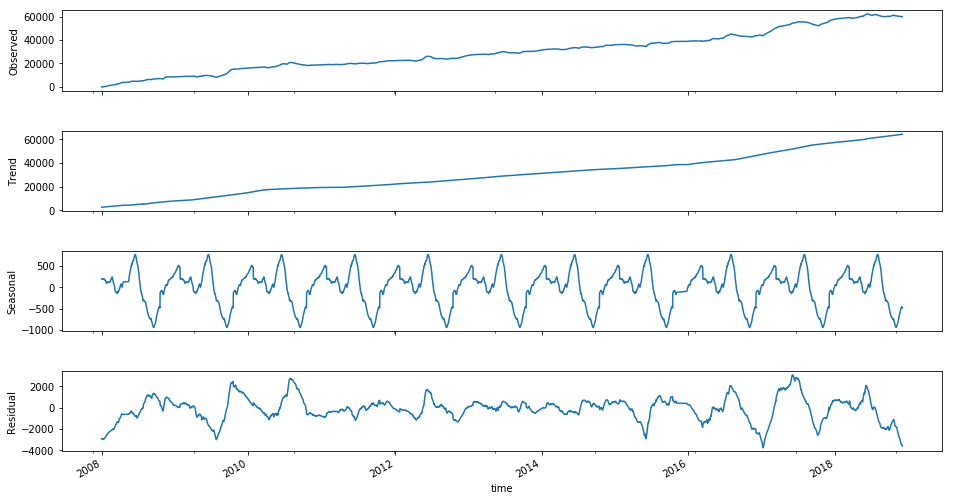

In [7]:
# seasonal decomposition
period = 365
na_values_output = np.nan

decomposition = tsa.seasonal_decompose(data['despiked'],freq=period,extrapolate_trend='freq')

fig=decomposition.plot()
fig.set_size_inches(15,8)
#plt.savefig(pathlib.Path(res_pic))

data['trend'] = decomposition.trend.fillna(na_values_output)
data['seasonal'] = decomposition.seasonal.fillna(na_values_output)
data['residual'] = decomposition.resid.fillna(na_values_output)

Augmented Dickey–Fuller test for residual data:
  adf: -5.373578658946293
  p-value: 3.848002048806779e-06
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


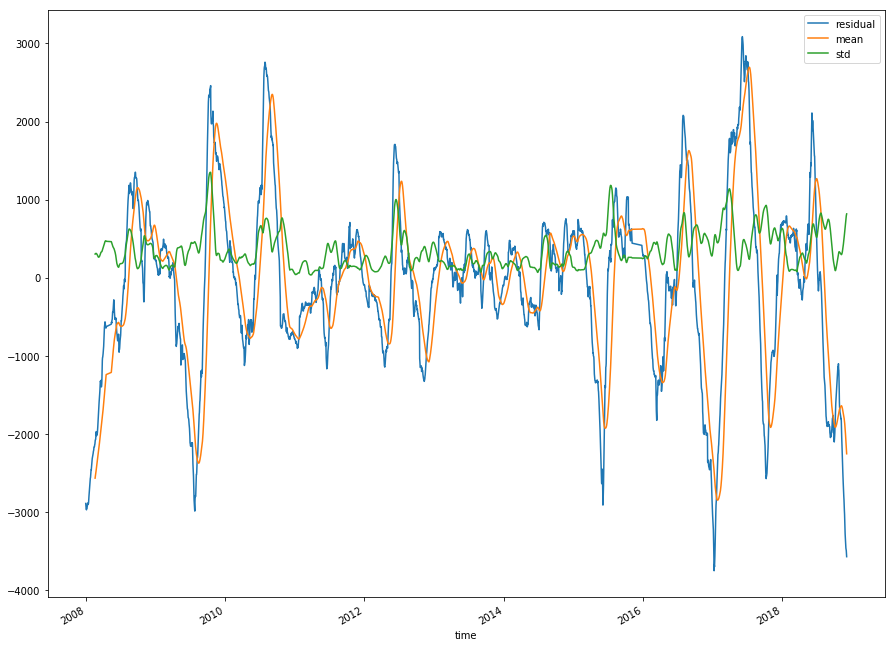

In [9]:
# test stationary on residual
res = tsa.adfuller(data['residual'].dropna().values)
tsa.print_adf(res,'residual data')
data['mean'] = data['residual'].rolling(window=window_size).mean()
data['std'] = data['residual'].rolling(window=window_size).std()
data.plot(figsize=(15,12),y=['residual','mean','std'])

In [10]:
# ARIMA
p = 5
d = 0
q = 1
P = 0
D = 0
Q = 0
s = 0
model = tsa.SARIMAX(data['residual'].dropna(),
                    order=(p,d,q),
                    seasonal_order=(P,D,Q,s),
                    enforce_stationarity=False)
res = model.fit()

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


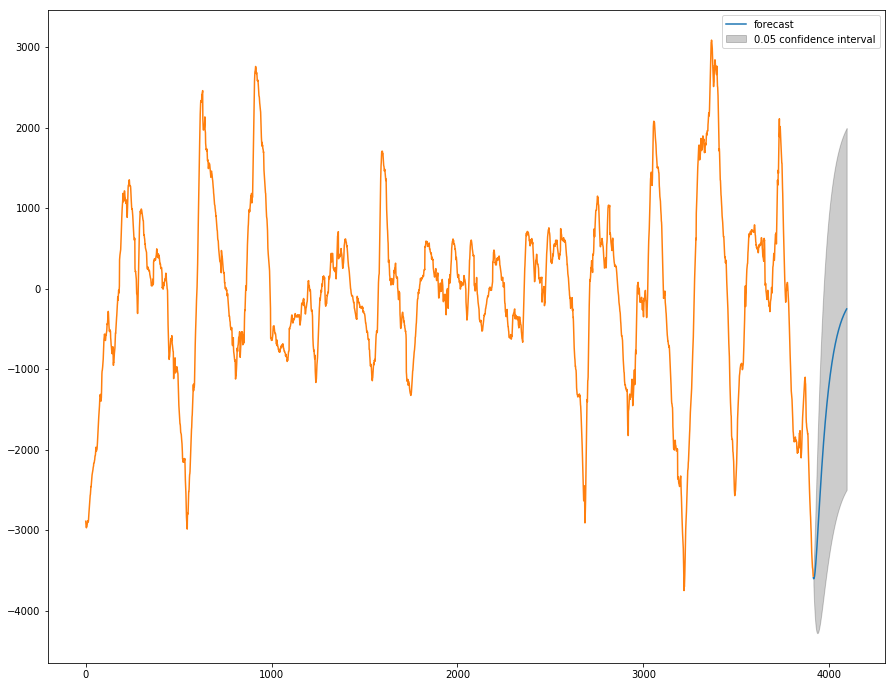

In [11]:
pred = res.get_forecast(180)
pci = pred.conf_int()
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
pred.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',alpha=0.2,label='0.05 confidence interval')
ax.plot(data['residual'].dropna().values)
ax.legend()

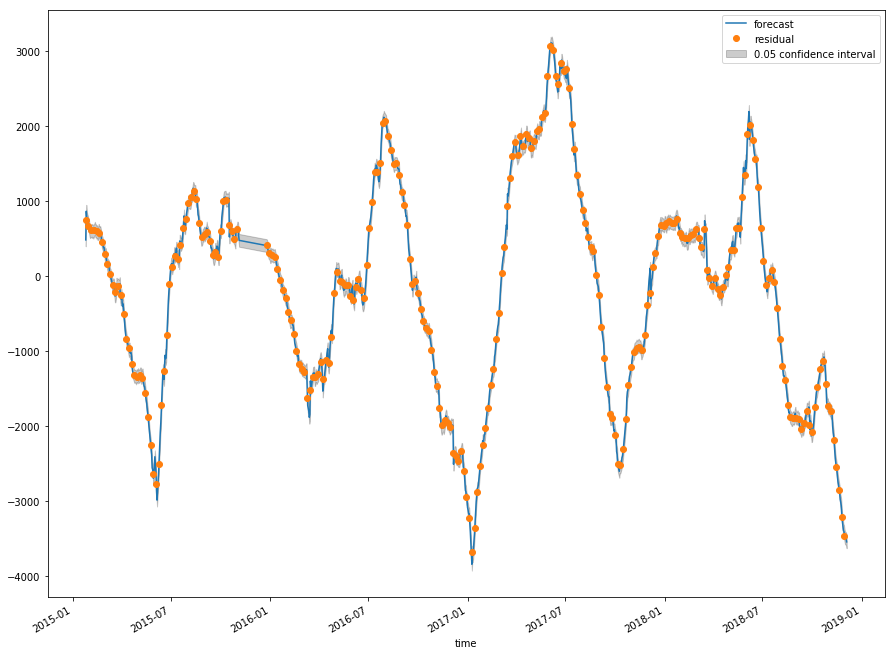

In [12]:
start_day=365*7
pred = res.get_prediction(start_day)
pci = pred.conf_int()
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
pred.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',alpha=0.2,label='0.05 confidence interval')
data['residual'].dropna().iloc[start_day:].asfreq('5d').plot(style='o',ax=ax)
ax.legend()

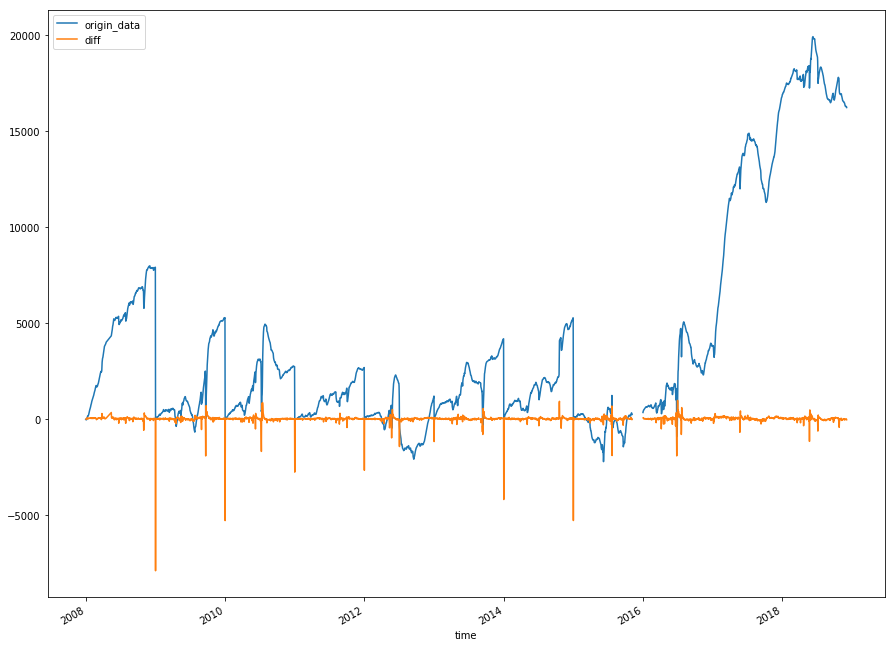

In [13]:
# first order difference
data['diff'] = data['origin_data'].diff()
ax = data.plot(figsize=(15,12),y=['origin_data','diff'])

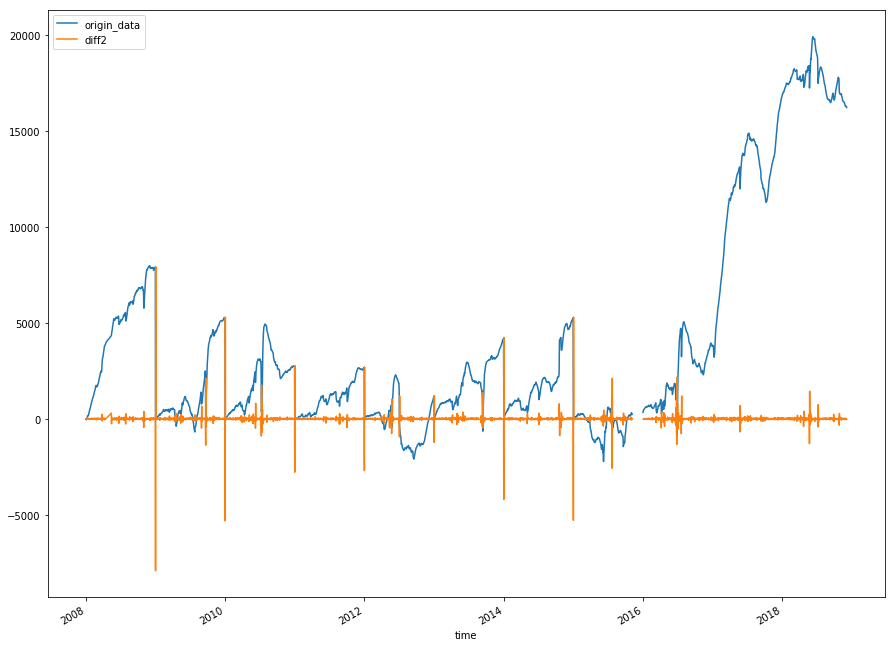

In [14]:
# second order difference
data['diff2'] = data['diff'].diff()
ax = data.plot(figsize=(15,12),y=['origin_data','diff2'])

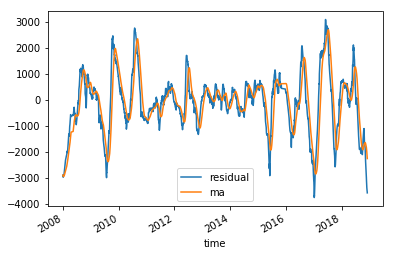

In [15]:
# moving average
window_size = 50
center = False
data['ma'] = data['residual'].rolling(window=window_size,center=center,min_periods=1).mean()
data.plot(y=['residual','ma'])

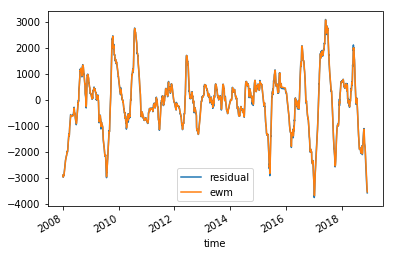

In [16]:
# exponential moving average
factor = 0.5
data['ewm'] = data['residual'].ewm(alpha=factor).mean()
data.plot(y=['residual','ewm'])

In [9]:
from geoist.snoopy.anomaly_detector import AnomalyDetector
ts = dict(zip(range(len(data)),data['residual'].values))
my_detector = AnomalyDetector(ts)

In [11]:
score = my_detector.get_all_scores()

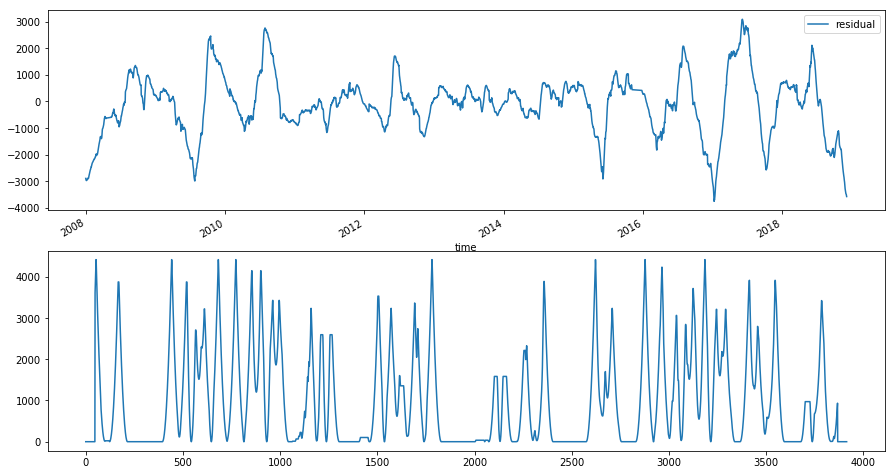

In [13]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(211)
data.plot(ax=ax,y=['residual'])
ax = fig.add_subplot(212)
ax.plot(score.timestamps,score.values)

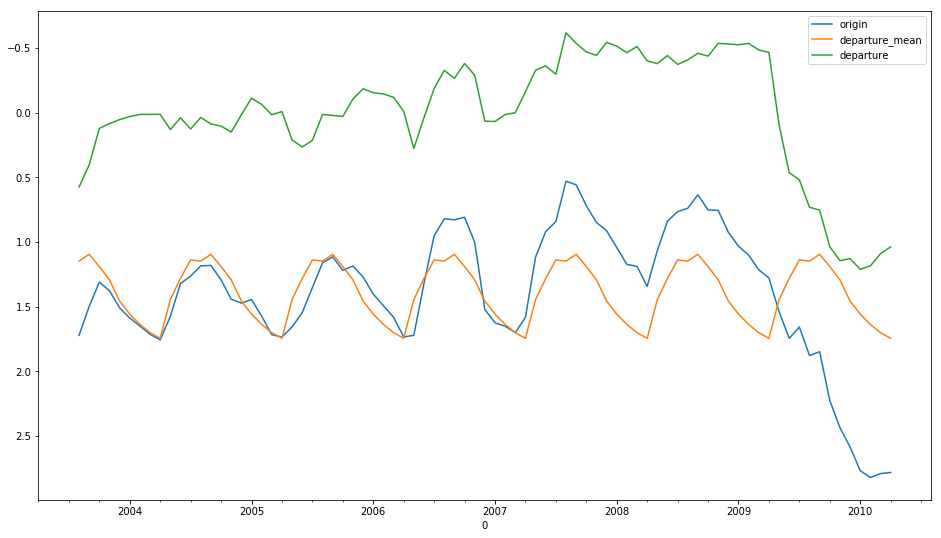

In [443]:
# Example of 距平分析
# load data
dateparser = lambda x: pd.to_datetime(x,format='%Y%m')
water = pd.read_csv('./data/water_level_res.txt',header=None,parse_dates=True,index_col=0,delim_whitespace=True,date_parser=dateparser)
water[water == 99999] = np.nan
water = water.interpolate()
water.columns = ['origin','mean','departure']
water_origin = pd.DataFrame(water[water.columns[0]]).copy()

# call departure, and plot.
water_origin,_ = tsa.despike_v2(water_origin,th=200)
res = tsa.departure(water_origin)
ax = res.plot(figsize=(16,9))
ax.invert_yaxis()

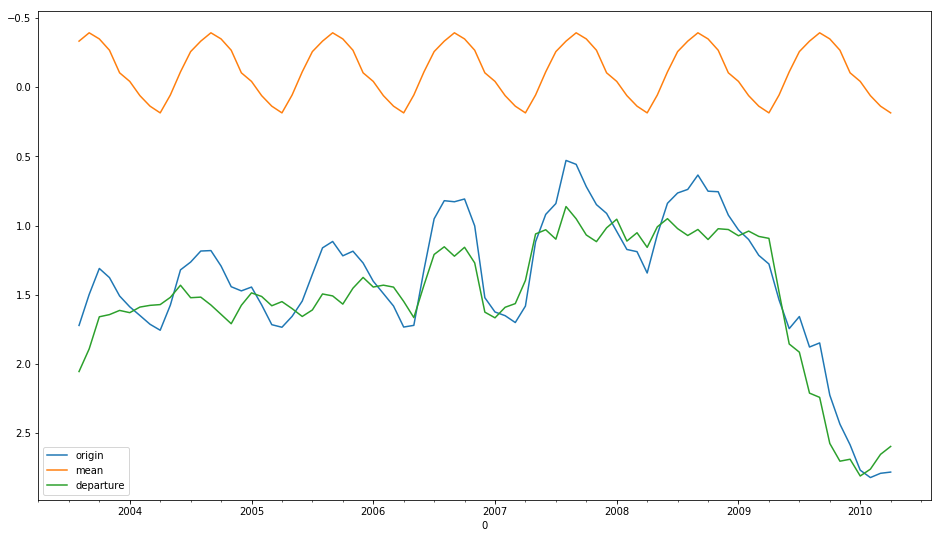

In [444]:
# old result
ax = water.plot(figsize=(16,9))
ax.invert_yaxis()

In [446]:
# upsample
water_daily = water_origin.resample('D').asfreq().interpolate()
water_daily.head(10)

,origin,departure_mean,departure
0,,,
2003-08-01,1.721300,1.147100,0.574200
2003-08-02,1.714074,1.145391,0.568683
2003-08-03,1.706848,1.143682,0.563167
2003-08-04,1.699623,1.141972,0.557650
2003-08-05,1.692397,1.140263,0.552134
2003-08-06,1.685171,1.138554,0.546617
2003-08-07,1.677945,1.136845,0.541100
2003-08-08,1.670719,1.135135,0.535584
2003-08-09,1.663494,1.133426,0.530067


In [447]:
# downsample
water_monthly = water_daily.resample('MS').asfreq().interpolate()
water_monthly.head(10)

,origin,departure_mean,departure
0,,,
2003-08-01,1.7213,1.147100,0.574200
2003-09-01,1.4973,1.094114,0.403186
2003-10-01,1.3096,1.188857,0.120743
2003-11-01,1.3756,1.291729,0.083871
2003-12-01,1.5085,1.455800,0.052700
2004-01-01,1.5868,1.556700,0.030100
2004-02-01,1.6493,1.636657,0.012643
2004-03-01,1.7129,1.700400,0.012500
2004-04-01,1.7559,1.743586,0.012314


In [450]:
# monthly mean
water_monthly = water_daily.resample('MS').mean().interpolate()
water_monthly.head(10)

,origin,departure_mean,departure
0,,,
2003-08-01,1.612913,1.121462,0.491451
2003-09-01,1.406578,1.139907,0.266672
2003-10-01,1.341535,1.238634,0.102902
2003-11-01,1.439835,1.371030,0.068805
2003-12-01,1.546387,1.504623,0.041765
2004-01-01,1.617042,1.595389,0.021653
2004-02-01,1.680003,1.667430,0.012574
2004-03-01,1.733706,1.721296,0.012410
2004-04-01,1.668272,1.599229,0.069043


/usr/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Text(0, 0.5, 'response')

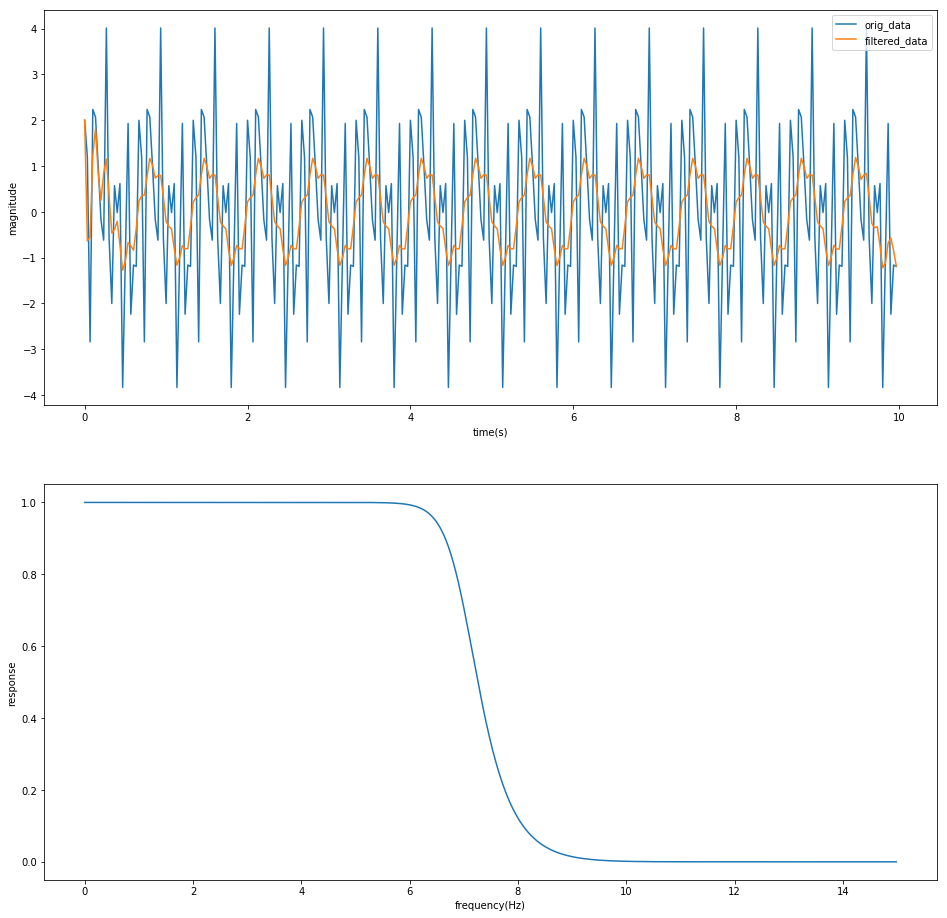

In [505]:
# filter
# generate dataset
sample_rate = 30.0
n = np.arange(300)
orig_data = np.sin(0.1*np.pi*n)+2.0*np.cos(0.5*np.pi*n)+1.5*np.sin(0.8*np.pi*n)

# generate filter
order = 10
nyq = 0.5*sample_rate
lower_cut_rate = 7.0 / nyq
upper_cut_rate = 10.0 / nyq
sos = tsa.butter(10,lower_cut_rate,btype='low',output='sos')

# apply filter to data
filtered_data = tsa.sosfiltfilt(sos,orig_data)

# plot data
fig = plt.figure(figsize=(16,16))
ax = plt.subplot(211)
ax.plot(n/sample_rate,orig_data,label='orig_data')
ax.plot(n/sample_rate,filtered_data,label='filtered_data')
ax.set_xlabel('time(s)')
ax.set_ylabel('magnitude')
ax.legend()
ax = plt.subplot(212)
w,h = tsa.sosfreqz(sos,worN=1000)
ax.plot(0.5*sample_rate*w/np.pi,np.abs(h))
ax.set_xlabel('frequency(Hz)')
ax.set_ylabel('response')

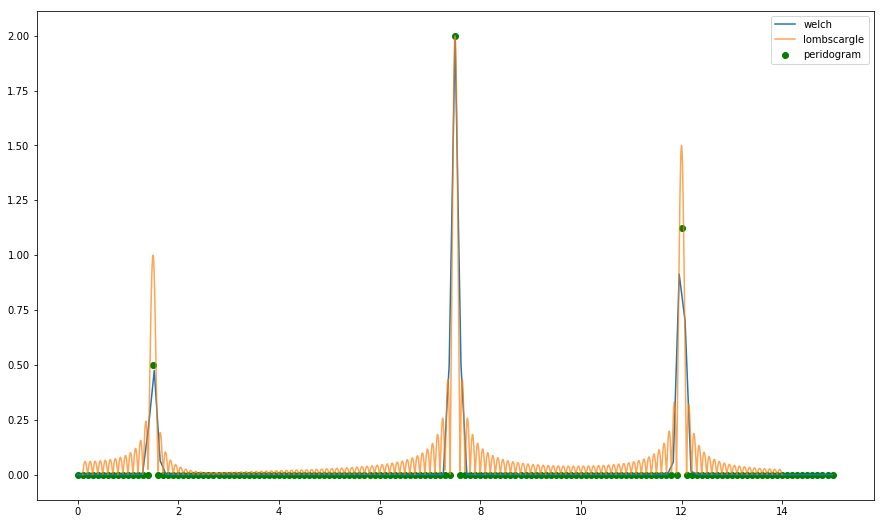

In [506]:
# psd
f_w,pxx_w = tsa.welch(orig_data,sample_rate,nperseg=256,scaling='spectrum')
f_p,pxx_p = tsa.periodogram(orig_data,sample_rate,scaling='spectrum')
f_l = np.linspace(0.1,14,3000)*np.pi*2.0
pxx_l = tsa.lombscargle(n/sample_rate,orig_data,f_l)

# plot result
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
ax.plot(f_w,pxx_w,label='welch')
ax.scatter(f_p,pxx_p,label='peridogram',c='g')
ax.plot(0.5*f_l/np.pi,np.sqrt(pxx_l*4.0/len(orig_data)),alpha=0.7,label='lombscargle')
ax.legend()

In [480]:
import importlib
importlib.reload(tsa)

<module 'geoist.snoopy.tsa' from '/usr/lib/python3.7/site-packages/geoist/snoopy/tsa.py'>